## Setup

In [1]:
import sys
import pandas as pd

import paths
import pickle

sys.path.append("..")
from models.utils import *
from models.plotting_utils import *
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from models import train_alt, CNN1D, CNN2D

import matplotlib.pyplot as plt

In [2]:
# A helper function to subset 30S, since now the surface vars exist for all longitudes - values taken from basin function!
def mask_30S(inputs):
    mask = np.logical_or(np.logical_or(np.logical_and(inputs.longitude >= -180, 
                                                      inputs.longitude <= -71),
                                       np.logical_and(inputs.longitude >= 31, 
                                                      inputs.longitude <= 115)),
                         np.logical_and(inputs.longitude >= 153, 
                                        inputs.longitude <= 180))
    masked = inputs.where(mask, drop = True)

    return masked

In [3]:
# A helper function to format the input files based on a given latitude
def format_lat_lon(value):
    """Format latitude or longitude with N/S or E/W suffix."""
    if value < 0:
        return f"{abs(value)}S"
    else:
        return f"{value}N"

## Experiment Variables

In [757]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]
lat = lats[3]

## Loading and processing relevant data

In [758]:
# Retrieve the input covariates (ecco surface variables)
inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}.nc").isel(latitude=slice(1,2))
if lat == -30:
    inputs = mask_30S(inputs)  # when working at 30S, they have to be masked, otherwise not
if lat == -55:
    inputs = inputs.dropna('longitude', how = 'all')
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 720)
Coordinates:
  * latitude   (latitude) float32 -59.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

In [759]:
# Retrieve the output streamfunctions to train on (in density space)
outputs_fp = f"{data_home}/ecco_data_minimal/{format_lat_lon(lat)}_moc_density.pickle"

with open(outputs_fp, 'rb') as f:
    outputs = pickle.load(f).astype(np.float64)
outputs = np.expand_dims(outputs, 1) # grabbing just 30S

outputs = xr.Dataset(
            data_vars = {'moc' : (["time", "latitude"], outputs)}, 
            coords = {'time' : inputs.time, 'latitude' : np.atleast_1d(lat),}
        )

outputs

<xarray.Dataset>
Dimensions:   (time: 312, latitude: 1)
Coordinates:
  * time      (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
  * latitude  (latitude) int32 -60
Data variables:
    moc       (time, latitude) float64 -13.38 -14.45 -6.522 ... 2.564 -15.85

In [760]:
def align_dates(inputs, outputs):

    # Align the dates according to the data available for in- and output
    date_range = (inputs.time.values[0], inputs.time.values[-1]) # grabbing start and end date for inputs
    date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
    print('Date range to align to:', date_range)
    return align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

In [761]:
def preprocess_inputs(inputs, history=1, coords = ["time"]):

    pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

    return reshape_inputs(pp_data_surface, history=history, keep_coords=coords, data_vars=["OBP", "ZWS"])

In [762]:
def preprocess_outputs(outputs, X):
    # MOC strength preprocessing
    strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
    strength_np = strength.moc.squeeze().values
    
    # Necessary step to do convolutions along the right axis with pytorch tensors!
    dims = list(range(X.ndim))  
    dims[1], dims[-1] = dims[-1], dims[1]
    X = np.transpose(X, dims)

    conv_dims = 1
    if len(X.shape) == (conv_dims + 1):
        X = np.expand_dims(X, axis=-1)

    y = strength_np[-X.shape[0]:]
    
    """
    print()
    print('Inputs shape:', X.shape)
    print('Extra inputs shape:', X_extra.shape)
    print('Outputs shape:', y.shape)
    """
    return y

In [763]:
def define_train_and_validation_sets(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None, random_state=123456)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, stratify=None, random_state=123456)

    device = "cuda" if t.cuda.is_available() else "cpu"

    Xt_train = t.tensor(X_train, device=device).double()
    Yt_train = t.tensor(y_train, device=device).double()
    Xt_valid = t.tensor(X_valid, device=device).double()
    Yt_valid = t.tensor(y_valid, device=device).double()
    Xt_test = t.tensor(X_test, device=device).double()
    Yt_test = t.tensor(y_test, device=device).double()
    return Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test

## Running Neural Networks Trainings

In [764]:
def get_input(outputs, inputs, history=1):

    inputs, outputs = align_dates(inputs, outputs)
    X = preprocess_inputs(inputs, history=history)
    print(X.shape)
    y = preprocess_outputs(outputs, X)
    
    return define_train_and_validation_sets(X, y)

In [765]:
# Hyperparameters to tune
dropout = 0.1
n_pure_layers = 1
n_mix_layers = 1
n_channels_mult = 5
kernel_size = 5            #For 2D input change this to (3x3)
model_iterations = 1

In [766]:
import importlib
importlib.reload(train_alt)

<module 'models.train_alt' from 'C:\\Users\\aline\\OTP\\models\\train_alt.py'>

In [767]:
def train_CNN(Xt_train, Yt_train):

    model = CNN1D.CNN1D(
        n_pure_layers=n_pure_layers, 
        n_mix_layers=n_mix_layers, 
        n_features=Xt_train.shape[1], 
        n_channels=Xt_train.shape[1]*n_channels_mult,
        kernel_size=kernel_size,
        dropout=dropout, 
    )

    model, train_loss = train_alt.train_model( #, val_loss
        model=model, 
        X_train = Xt_train, 
        y_train = Yt_train, 
        #X_val = Xt_valid,
        #y_val = Yt_valid, 
        #early_stopping=True,
    )
    return model

In [768]:
def predict_CNN(model, Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, y_test):
    model =  model.double()

    # Extracting all predictions in time order
    train_set_pred = train_alt.predict(model, Xt_train, Yt_train)
    valid_set_pred = train_alt.predict(model, Xt_valid, Yt_valid)
    test_set_pred = train_alt.predict(model, Xt_test, y_test)
    
    predictions = {
        "train_set_pred": train_set_pred, 
        "valid_set_pred": valid_set_pred, 
        "test_set_pred": test_set_pred, 
        "all_preds": np.concatenate([train_set_pred, valid_set_pred, test_set_pred])
    }
    
    print('test set', np.array(test_set_pred).shape)
    print(y_test.shape)
    
    metrics = {
        "rmse": round(root_mean_squared_error(test_set_pred, y_test), 3),
        "mae": round(mean_absolute_error(test_set_pred, y_test), 3),
        "mape": round(mean_absolute_percentage_error(test_set_pred, y_test), 3)*100,        
        "cmape": round(custom_MAPE(np.array(test_set_pred).squeeze(), y_test.detach().cpu().numpy(), threshold=0.5), 3)*100,
        "test_corr": round(np.corrcoef(np.array(test_set_pred).squeeze(), y_test)[0, 1], 3),
        }
    
    return predictions, metrics

In [769]:
# To loop over several models and compare the performances
models = []
history = 12
for i in range(history):
    Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = get_input(outputs, inputs, history=i+1)
    Xt_train.shape
    models.append(train_CNN(Xt_train, Yt_train))

predictions_models = []
metrics_models = []

for i in range(len(models)):
    Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test = get_input(outputs, inputs, history=i+1)
    predictions, metrics = predict_CNN(models[i], Xt_train, Yt_train, Xt_valid, Yt_valid, Xt_test, Yt_test )
    predictions_models.append(predictions)
    metrics_models.append(metrics)

metrics_df = pd.DataFrame(metrics_models)
summary_metrics_df = pd.DataFrame({
                "mean": metrics_df.mean().round(3), 
                "std": metrics_df.std().round(3)}
            )
display(summary_metrics_df)

predictions_df = pd.DataFrame(predictions_models)

Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (312, 1, 2)
(312, 1, 2)
device: cpu
91 parameters.


100%|██████████| 5000/5000 [00:24<00:00, 204.57it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (311, 2, 2)
(311, 2, 2)
device: cpu
231 parameters.


100%|██████████| 5000/5000 [01:10<00:00, 70.92it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (310, 3, 2)
(310, 3, 2)
device: cpu
421 parameters.


100%|██████████| 5000/5000 [01:12<00:00, 69.35it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (309, 4, 2)
(309, 4, 2)
device: cpu
661 parameters.


100%|██████████| 5000/5000 [01:18<00:00, 64.08it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (308, 5, 2)
(308, 5, 2)
device: cpu
951 parameters.


100%|██████████| 5000/5000 [01:14<00:00, 67.57it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (307, 6, 2)
(307, 6, 2)
device: cpu
1291 parameters.


100%|██████████| 5000/5000 [01:10<00:00, 71.15it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (306, 7, 2)
(306, 7, 2)
device: cpu
1681 parameters.


100%|██████████| 5000/5000 [01:11<00:00, 70.35it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (305, 8, 2)
(305, 8, 2)
device: cpu
2121 parameters.


100%|██████████| 5000/5000 [01:17<00:00, 64.18it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (304, 9, 2)
(304, 9, 2)
device: cpu
2611 parameters.


100%|██████████| 5000/5000 [01:34<00:00, 52.79it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (303, 10, 2)
(303, 10, 2)
device: cpu
3151 parameters.


100%|██████████| 5000/5000 [01:38<00:00, 50.52it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (302, 11, 2)
(302, 11, 2)
device: cpu
3741 parameters.


100%|██████████| 5000/5000 [01:02<00:00, 80.39it/s] 


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (301, 12, 2)
(301, 12, 2)
device: cpu
4381 parameters.


100%|██████████| 5000/5000 [00:38<00:00, 130.01it/s]


Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (312, 1, 2)
(312, 1, 2)
test set (63, 1)
torch.Size([63])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (311, 2, 2)
(311, 2, 2)
test set (63, 1)
torch.Size([63])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (310, 3, 2)
(310, 3, 2)
test set (62, 1)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (309, 4, 2)
(309, 4, 2)
test set (62, 1)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
variables: ['OBP', 'ZWS']
shape: (308, 5, 2)
(308, 5, 2)
test set (62, 1)
torch.Size([62])
Date range to align to: ('1992-01-16', '2017-12-16')
axes: ['time', 'history', 'feature']
varia

,mean,std
rmse,7.868,2.824
mae,6.480,2.388
mape,61.992,29.140
cmape,52.742,12.886
test_corr,0.714,0.109


In [696]:
# For each of the trained models, retrieve the predictions and according metrics
predictions, metrics = zip(*[predict_CNN(model) for model in models])

summary_metrics_df = pd.DataFrame(metrics).agg(['mean', 'std']).round(3).T
display(summary_metrics_df)

TypeError: predict_CNN() missing 6 required positional arguments: 'Xt_train', 'Yt_train', 'Xt_valid', 'Yt_valid', 'Xt_test', and 'y_test'

In [770]:
metrics_df.to_csv(f"{paths.LOCAL_DIR}/{lat}_history.csv")

In [771]:
plot_30 = pd.read_csv(f"{paths.LOCAL_DIR}/-30_history.csv")
plot_55 = pd.read_csv(f"{paths.LOCAL_DIR}/-55_history.csv")
plot_60 = pd.read_csv(f"{paths.LOCAL_DIR}/-60_history.csv")

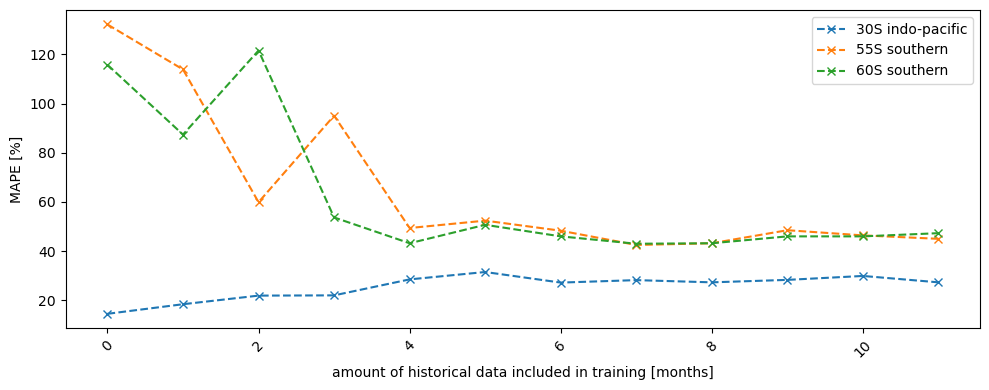

In [779]:
# Plotting
plt.figure(figsize=(10, 4))  # Optional: specifies the figure size
plt.plot(plot_30.index, plot_30['mape'], marker='x', linestyle='--', linewidth=1.5, label='30S indo-pacific')  
plt.plot(plot_55.index, plot_55['mape'], marker='x', linestyle='--', linewidth=1.5, label='55S southern') 
plt.plot(plot_60.index, plot_60['mape'], marker='x', linestyle='--', linewidth=1.5, label='60S southern') 
plt.xlabel('amount of historical data included in training [months]')
plt.ylabel('MAPE [%]')
plt.legend()
plt.xticks(rotation=45)  # Rotates x-axis labels for better readability
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()

## Output visualisation

In [780]:
predictions_df = pd.DataFrame(predictions)
mean_y = {col: np.mean(np.stack(predictions_df[col].values), axis=0) for col in predictions_df}

time = outputs.time.values[-X.shape[0]:]
fig, ax = timeseries_comparison(mean_y['all_preds'], y, time, len(X_train))
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

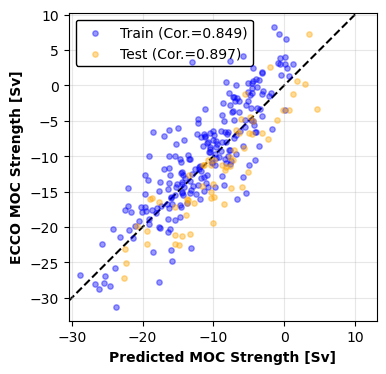

In [591]:
# Alternate view: looking at a scatterplot of predicted vs. actual
y_pred_train = np.array(mean_y['train_set_pred']).squeeze()
y_pred_test = np.array(mean_y['test_set_pred']).squeeze()

fig, ax = pred_vs_actual(y_pred_train, y_pred_test, y_train, y_test)
plt.show()